# Mixtures of conjugate priors 01 - Stan

## _Josep Fortiana_ &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2023-03-27

## The spinning coin

***
###### LaTeX macros
$ \def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\expdist{\operatorname{Exp}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
***

In [2]:
require(rstan,quietly=TRUE)
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

## Specify model

Stan is unable to simulate discrete parameters.

One possible workaround is to generate on the spot the unnamed index selecting which of both components
in the mixture is chosen:

If $u\sim\unifdist(0,1)$ and $\gamma\in(0,1)$ then $\prob(u<\gamma)=\gamma$.

We implement this with the ternary infix conditional operator.

In [3]:
modelString = "
    data{
        int<lower=0> n ;
        int<lower=0> x ; 
        real<lower=0> a1 ;
        real<lower=0> b1 ;
        real<lower=0> a2 ;
        real<lower=0> b2 ;
        real<lower=0,upper=1>  gamma ;
        }
    parameters{
        real<lower=0,upper=1>  u ;
        vector<lower=0,upper=1>[2] theta ;
        }
    transformed parameters{                         
        real<lower=0,upper=1> p ;                   
                                                    // Here the trick:
                                                    // Generate on the spot the unnamed index selecting 
                                                    // which of both components in the mixture is chosen
        p=theta[u<gamma?1:2] ;
        }
    model{
        x ~ binomial(n,p) ;
        theta[1]~beta(a1,b1) ;
        theta[2]~beta(a2,b2) ;
        u ~ uniform(0,1) ; 
        }"

## Compile model and sample from the posterior pdf

In [4]:
# Translate model to C++ and compile to DSO:
stanDso <- stan_model( model_code=modelString ) 

## Data 

In [5]:
prior.alpha1<-10
prior.beta1<-20
prior.alpha2<-20
prior.beta2<-10
prior.gamma<-0.5

In [6]:
# Number of trials
n<-10
# Observed x
x.obs<-3

In [7]:
Mix.01.Standat<-list(a1=prior.alpha1,b1=prior.beta1,a2=prior.alpha2,b2=prior.beta2,gamma=prior.gamma,n=n,x=x.obs)

In [8]:
# Generate posterior sample:
stanFit <- sampling( object=stanDso, 
                     data = Mix.01.Standat, 
                     chains = 3,
                     iter = 6000, 
                     warmup = 1000, 
                     thin = 1)

Warning message:
"There were 8346 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


In [9]:
# Generate posterior sample:
stanFit <- sampling( object=stanDso, 
                     data = Mix.01.Standat, 
                     chains = 3,
                     iter = 8000, 
                     warmup = 1000, 
                     thin = 1,
                     control=list(max_treedepth=12) )

In [10]:
S<-summary(stanFit)
round(S$summary,5)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
u,0.29719,0.00264,0.20954,0.01166,0.13150,0.27384,0.41665,0.86482,6307.987,0.99995
theta[1],0.32408,0.00077,0.07330,0.18648,0.27248,0.32208,0.37400,0.47207,9002.051,1.00017
theta[2],0.65808,0.00102,0.08808,0.47562,0.59930,0.66152,0.72086,0.81861,7466.834,1.00001
p,0.34963,0.00120,0.10571,0.19095,0.27944,0.33229,0.39508,0.63332,7702.498,0.99995
lp__,-47.55739,0.01891,1.44758,-51.22220,-48.33381,-47.19145,-46.44654,-45.83849,5857.652,1.00050


# Diagnostic diagrams with the `bayesplot` package

In [11]:
#install.packages("bayesplot", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(bayesplot,quietly=TRUE)

This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting



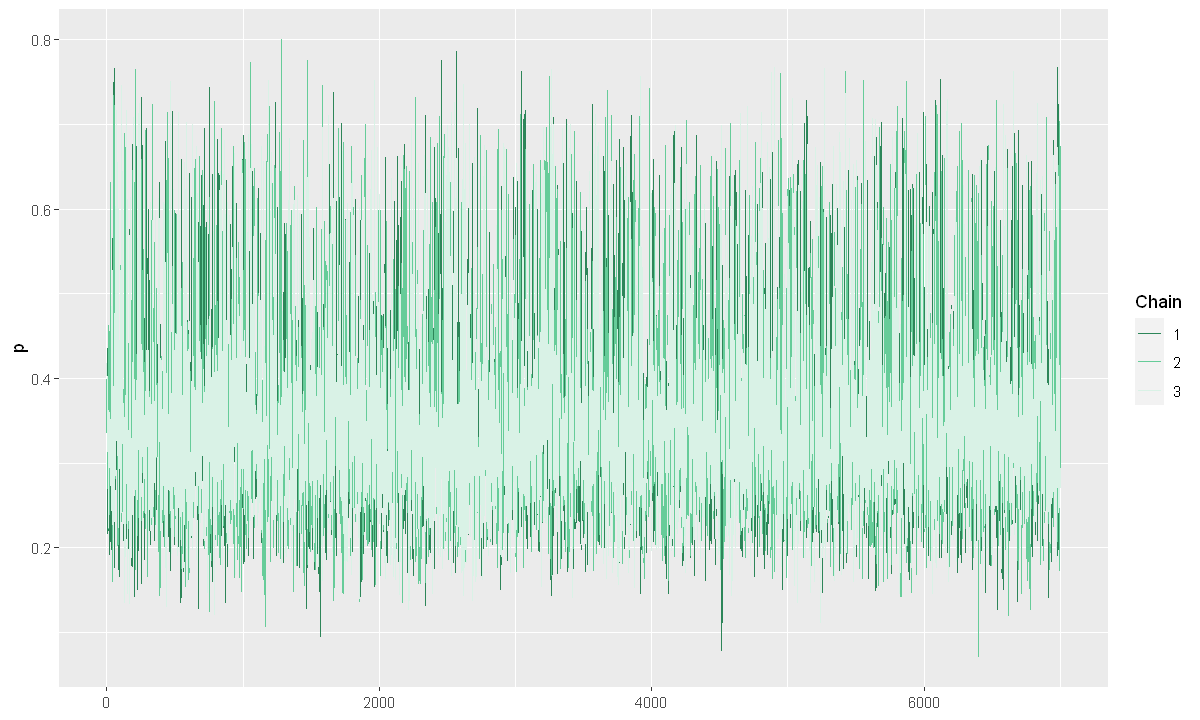

In [12]:
color_scheme_set("green")
options(repr.plot.width=10,repr.plot.height=6)
mcmc_trace(stanFit, pars = c("p"))

# Analysis of posterior pdf properties

### Posterior credible interval 

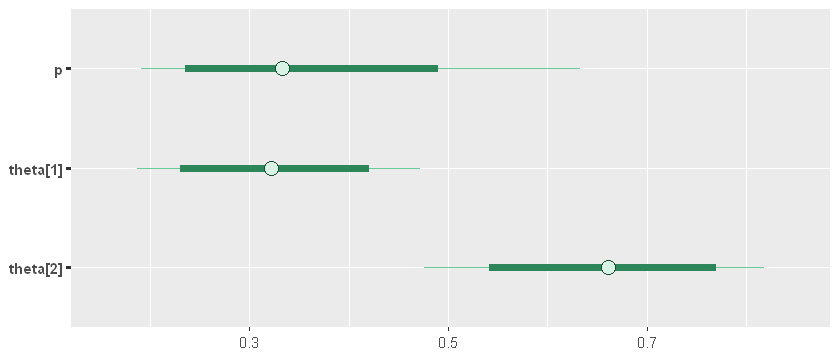

In [13]:
color_scheme_set("green")
options(repr.plot.width=7,repr.plot.height=3)
mcmc_intervals(stanFit, pars = c("p","theta[1]","theta[2]"),prob=0.80,prob_outer=0.95)
# Defaults are
# prob = 0.5,
# prob_outer = 0.9,

### Areas diagram

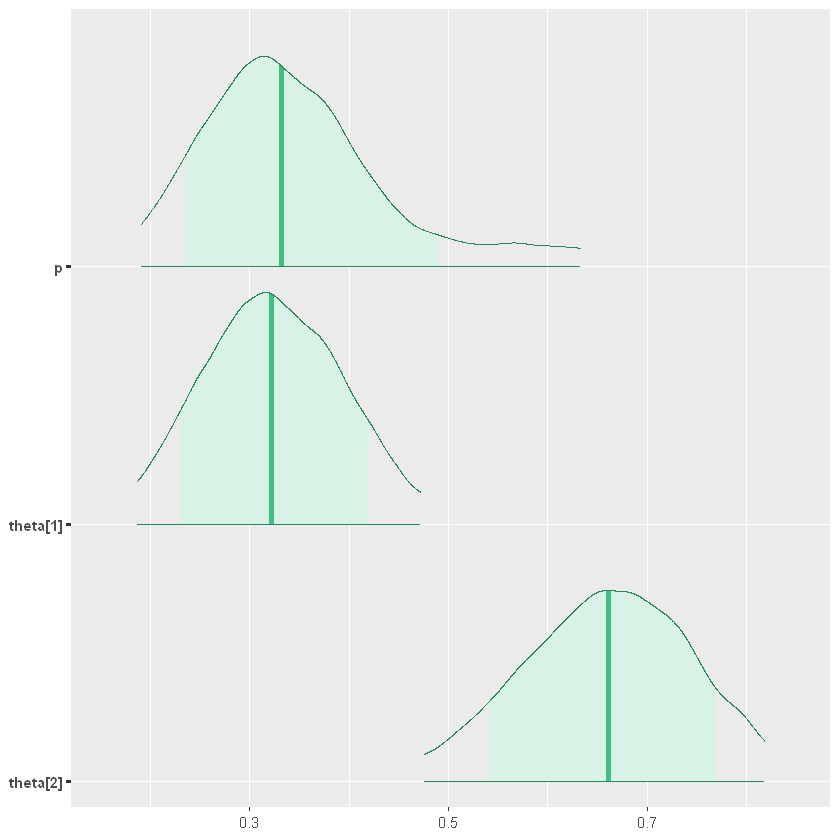

In [14]:
color_scheme_set("green")
options(repr.plot.width=7,repr.plot.height=7)
mcmc_areas(stanFit, pars = c("p","theta[1]","theta[2]"),prob=0.80,prob_outer=0.95)

### Histogram

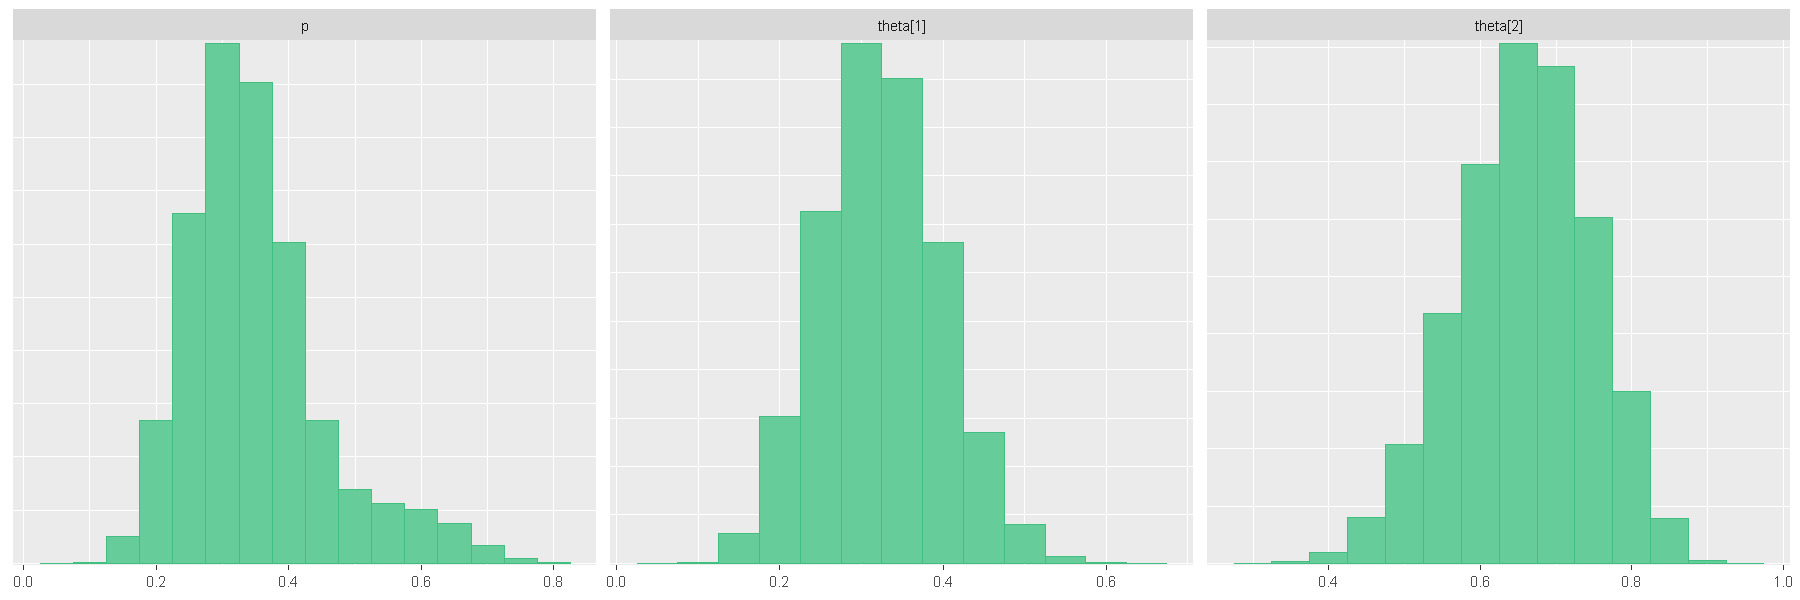

In [15]:
color_scheme_set("green")
options(repr.plot.width=15,repr.plot.height=5)
mcmc_hist(stanFit, pars = c("p","theta[1]","theta[2]"),binwidth=0.05)

### Density plot

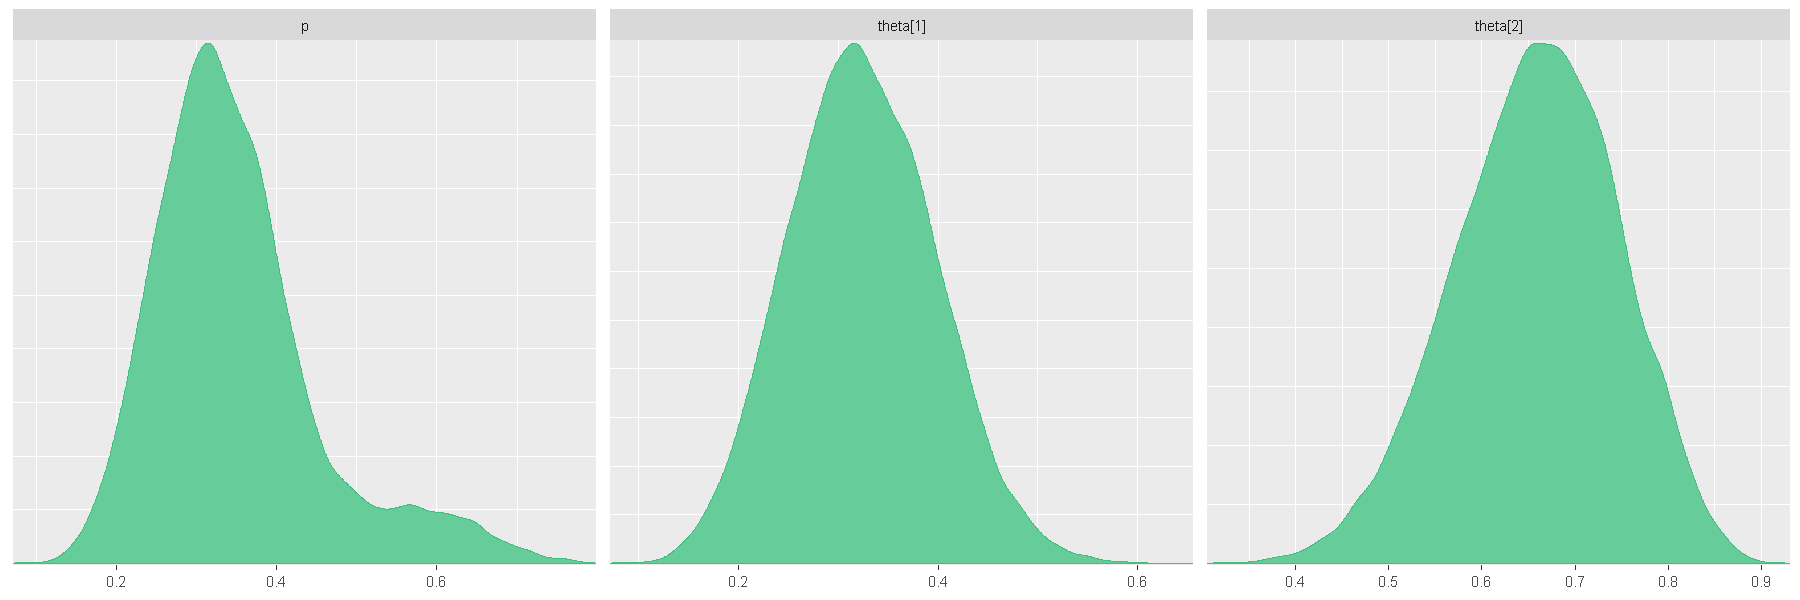

In [16]:
options(repr.plot.width=15,repr.plot.height=5)
mcmc_dens(stanFit, pars = c("p","theta[1]","theta[2]"))

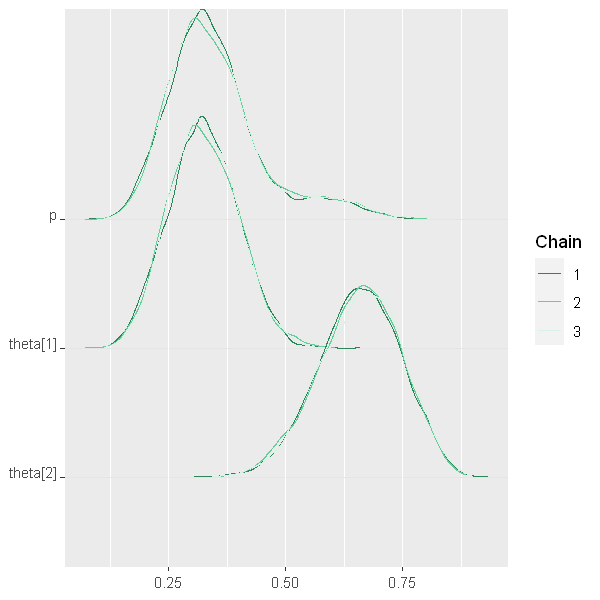

In [17]:
color_scheme_set("green")
options(repr.plot.width=5,repr.plot.height=5)
mcmc_dens_chains(stanFit, pars = c("p","theta[1]","theta[2]"))

### Violin plot

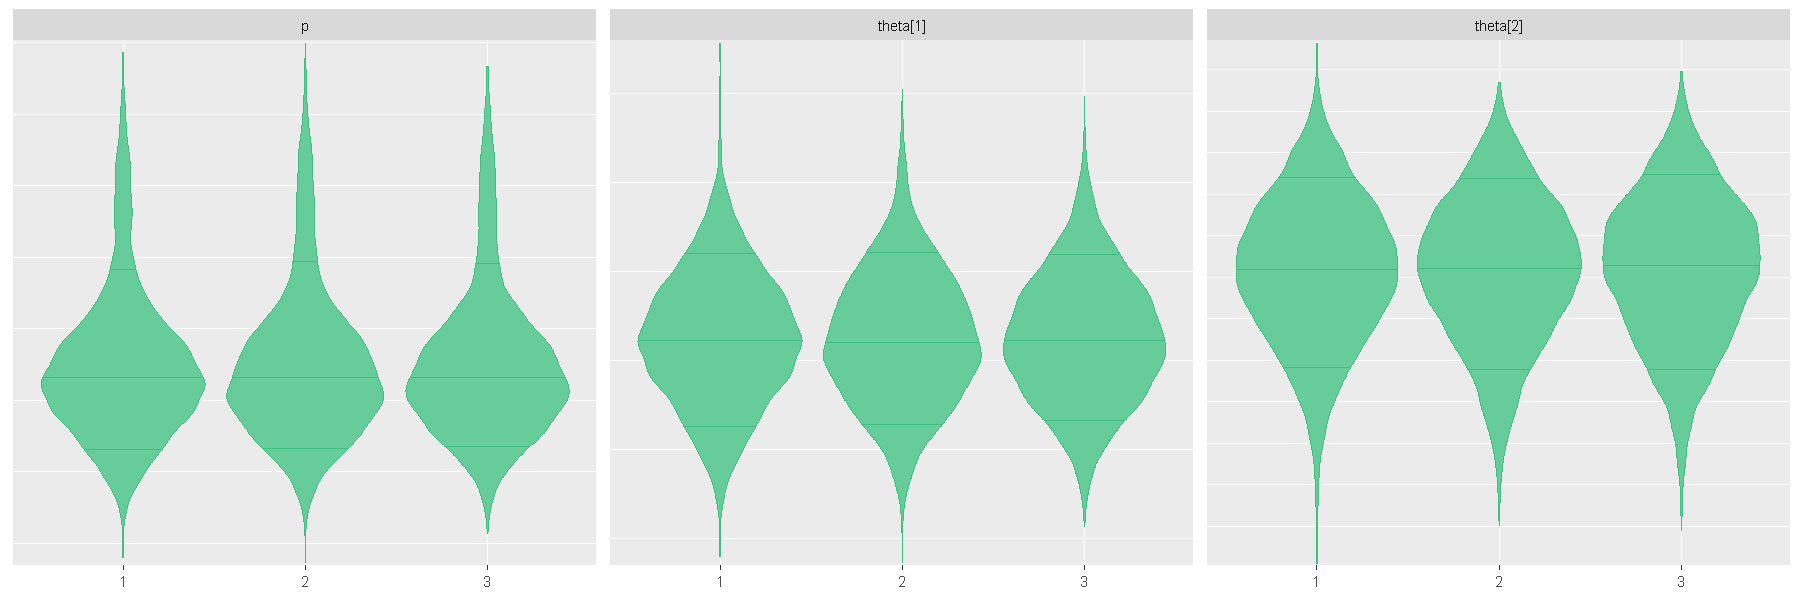

In [18]:
color_scheme_set("green")
options(repr.plot.width=15,repr.plot.height=5)
mcmc_violin(stanFit, pars = c("p","theta[1]","theta[2]"))